### One Shot Transfer Learning for modified Van der Pols Oscillator
$$
\begin{align*}
\frac{dy}{dt} &= y^2 - y^3
\end{align*}
$$
with initial conditions $y_0=\delta$ and domain $t \in [0, \frac{2}{\delta}]$ the stiffness parameter for $\delta < 10^{-3}$.  
After the change of variable $s=t\delta$
$$
\begin{align*}
\frac{dy}{ds} &= \frac{1}{\lambda}(\beta y^2 - \beta y^3)
\ \ \text{with} \ \ \lambda=\beta \delta
\end{align*}
$$
with initial conditions $y_0=\delta$ and domain $t \in [0, 2]$ the stiffness parameter for $\delta < 10^{-3}$.

Then by $\beta$-perturbation expansion and $\tilde{y}=\sum_{i=0}^{\infty}\beta^iY_i$ with have these systems for the various power of $\beta^i$ with $i=0, 1, 2, ...$
$$
\begin{align*}
\frac{dY_i}{ds} &= f_i \\
\end{align*} \\
\begin{align*}
f_i = \begin{cases}
0 \ \text{for} \ i \in \{0\} \\
\frac{1}{\lambda}(-\sum_{a+b+c=i-1}^{0<a,b,c<p}\phi(a,b,c)Y_aY_bY_c \ \ \text{with} \ \phi(a,b,c)=\begin{cases}
6 \ \text{if} \ a\ne b\ne c \\
1 \ \text{if} \ a=b=c \\
3 \ \text{otherwise}
\end{cases}+
\sum_{a+b=i-1}^{0<a,b,<p}\phi(a,b)Y_aY_b \ \ \text{with} \ \phi(a,b)=\begin{cases}
1 \ \text{if} \ a=b \\
2 \ \text{otherwise}
\end{cases})
\end{cases}
\end{align*}
$$

So these are linear system with A = $
\begin{bmatrix}
  0
\end{bmatrix}
$ and f = $\begin{bmatrix}
  f_i 
\end{bmatrix}$


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# imports
import torch
import matplotlib.pyplot as plt
import numpy as np
import sys
from scipy.integrate import solve_ivp

# Add parent directory to sys.path
from pathlib import Path
current_path = Path.cwd()
parent_dir = current_path.parent.parent
sys.path.append(str(parent_dir))

# Import necessary modules
from src.utils_plot import plot_loss_and_all_solution
from src.load_save import load_run_history
from src.transfer_learning import compute_H_and_dH_dt, analytically_compute_weights

from src.utils_plot import plot_transfer_learned_and_analytical

torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

In [3]:
def check_versions_and_device():
  # set the device to the GPU if it is available, otherwise use the CPU
  current_dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  if torch.cuda.is_available():
    torch.cuda.empty_cache()
  !nvidia-smi
  return current_dev

# set a global device variable to use in code
dev = check_versions_and_device()
print(dev)


Wed Jan 17 14:37:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.13                 Driver Version: 537.13       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   35C    P3              N/A /  20W |      0MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

C:\Users\Emilien\AppData\Local\Temp\ipykernel_15492\77114956.py:22: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([force[0].detach().item() - A[0] * y[0]])


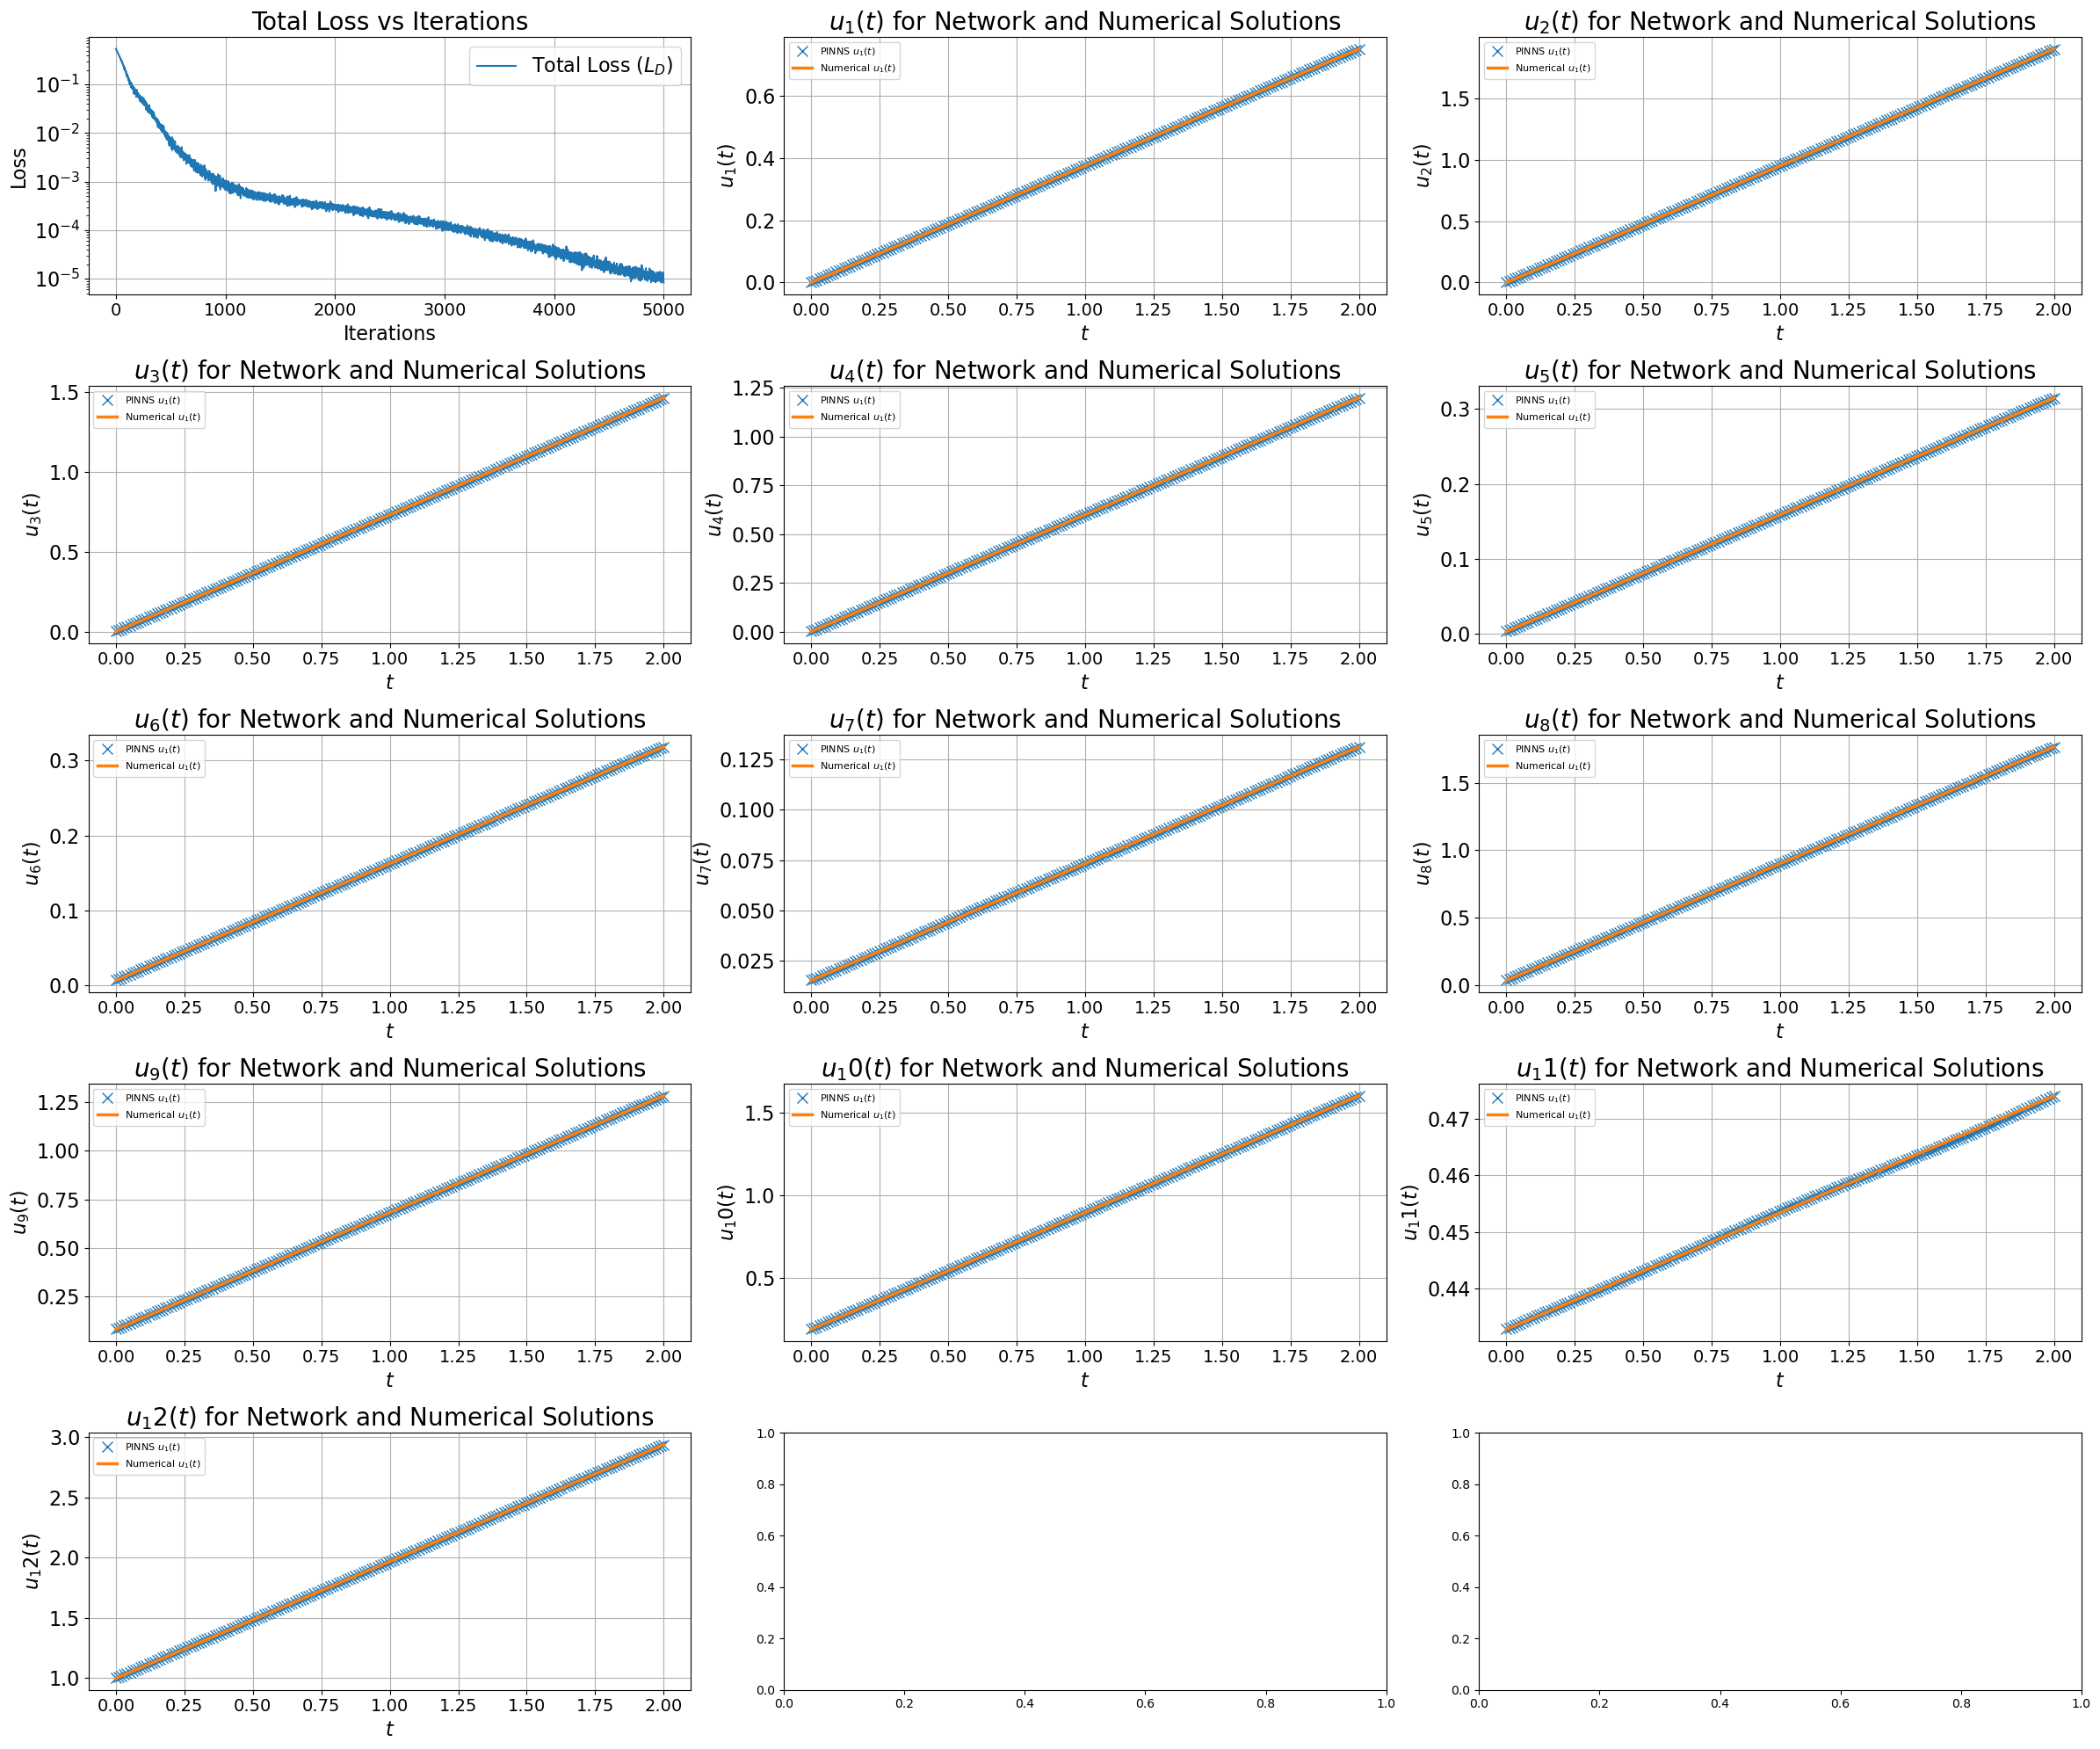

In [4]:
file_name = "inference_1161221"
equation_name = "FP"

trained_model, \
x_range, \
iterations, \
hid_lay, \
num_equations, \
num_heads, \
loss_hist, \
alpha_list, \
A_list, \
IC_list, \
force_list = load_run_history(equation_name, file_name, dev, prev=False)

# create the A matrix associated with the ODE
def get_A():
    return torch.tensor([[0]], device=dev).double() 

# function to numerically compute the solution to any set of two coupled, linear first-order ODES
def double_coupled_equation(t, y, A, force):
    return np.array([force[0].detach().item() - A[0] * y[0]])

numerical_sol_fct = lambda x, v, A, force: (solve_ivp(double_coupled_equation, [x_range[0], x_range[1]],
                                                    v, args=(A, force), t_eval=x.squeeze()).y)

plot_loss_and_all_solution(x_range=x_range, true_functs=numerical_sol_fct,
                           trained_model=trained_model, v_list=IC_list, A_list=A_list,
                           force=force_list, train_losses=loss_hist['L_total'],
                           loss_label='Total Loss ($L_D$)', device=dev)

## One-Shot Transfer Learning

In [5]:
# forward pass to extract H, H0 and dH/dt
size = 512
H, H_0, dH_dt_new, t_eval = compute_H_and_dH_dt(x_range[0], x_range[1], trained_model, num_equations, hid_lay, size, dev)
H = H.double()
H_0 = H_0.double()
dH_dt_new = dH_dt_new.double()
t_eval = t_eval.double()

Time to compute H and dH_dt:  1.899 seconds


Time to compute weights (given H and dH_dt):  0.283 seconds


C:\Users\Emilien\AppData\Local\Temp\ipykernel_15492\77114956.py:22: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([force[0].detach().item() - A[0] * y[0]])


mean 4.380707277238662e-10
max 5.536276859451376e-10


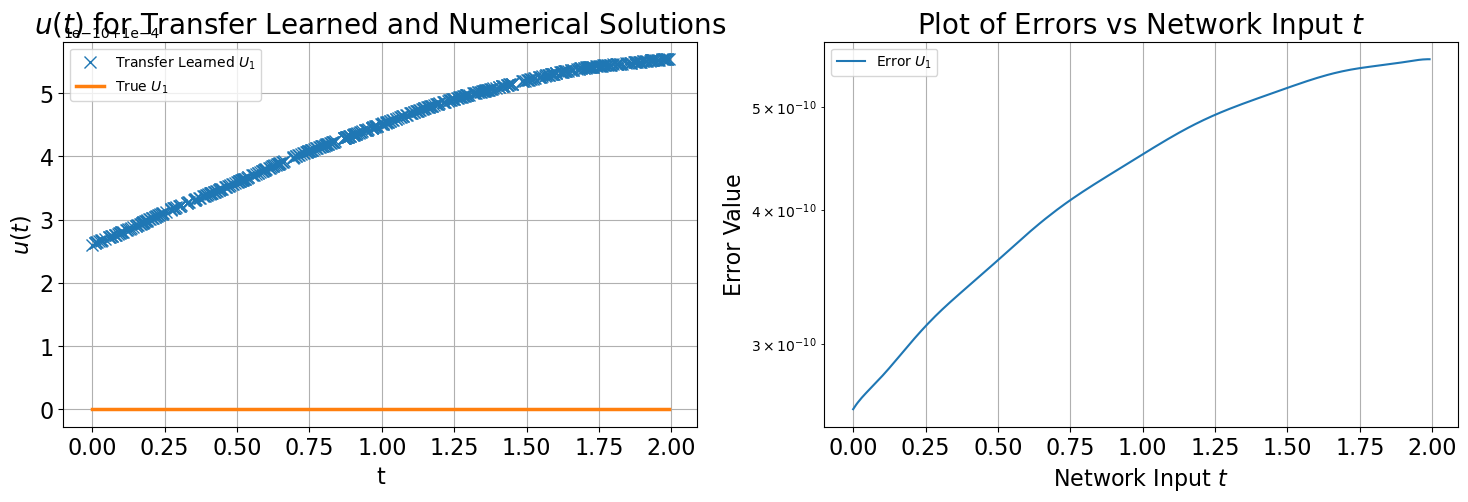

In [7]:
# Transfer on the linear system Choose alpha, IC and force to transfer on
A_transfer = get_A()
IC_transfer = torch.tensor([0.0001], device=dev, dtype=torch.float64)
force_transfer = torch.tensor([0.], device=dev, dtype=torch.float64)

M_inv, W_out, force_terms, total_time = analytically_compute_weights(dH_dt_new, H, H_0, t_eval,
                                                                     IC_transfer, A_transfer,
                                                                     force_transfer)
plot_transfer_learned_and_analytical(H, W_out, t_eval, IC_transfer, A_transfer,
                                     force_transfer, num_equations, numerical_sol_fct)

# Transfer learning to solve the non linear equation

In [8]:
beta = 0.00001

A_transfer = get_A()
IC_transfer = torch.tensor([0.01], device=dev, dtype=torch.float64)
force_transfer = torch.tensor([0.], device=dev, dtype=torch.float64)

alpha_transfer = beta*IC_transfer.item()
domain = (x_range[0], x_range[1]);

def numerical_non_linear_solution(delta, u0, domain, t_eval, r_tol= 1e-8):
  def F(t, y, delta=delta):
      return (1/delta)*(y[0]**2 - y[0]**3)
  solution = solve_ivp(F, domain, u0, t_eval=t_eval, r_tol=r_tol).y.squeeze()
  return solution

non_linear_num_sol = numerical_non_linear_solution(IC_transfer.item(), IC_transfer.detach().cpu(), domain, t_eval.detach().cpu().numpy().squeeze())

d:\Logiciel\Anaconda\envs\pinns\lib\site-packages\scipy\integrate\_ivp\common.py:39: UserWarning: The following arguments have no effect for a chosen solver: `r_tol`.
  warn("The following arguments have no effect for a chosen solver: {}."


In [1]:
from src.nonlinear_transfer_learning import solve_perturbation_TL

# functions to calculate the force function of each system p
def force_func_index(n):
    solution_index = [] # ind1, ind2, ind3, coeff
    for a in range(n+1):
        for b in range(a+1):
              for c in range(b+1):
                if ((a+b+c)==n):
                    if ((a==b) & (b==c)):
                        solution_index.append([a, b, c, 1])
                    elif ((a!=b) & (b!=c)):
                        solution_index.append([a, b, c, 6])
                    else:
                        solution_index.append([a, b, c, 3])
    for a in range(n+1):
      for b in range(a+1):
        if ((a+b)==n):
          if a==b:
            solution_index.append([a, b, 1])
          else:
            solution_index.append([a, b, 2])
    return solution_index

def force_function_PINNS(i, alpha, list_force_index, PINNS_list):
      result = 0
      for force_ind in list_force_index[i-1]:
        if len(force_ind) == 4:
          result -= force_ind[-1]*(PINNS_list[force_ind[0]][:, 0]*PINNS_list[force_ind[1]][:, 0]*PINNS_list[force_ind[2]][:, 0])
        else:
          result += force_ind[-1]*(PINNS_list[force_ind[0]][:, 0]*PINNS_list[force_ind[1]][:, 0])   
      return (1/alpha)*result

def force_function_numerical(i, alpha, list_force_index, numerical_pert_list):
      result = 0
      for j, force_ind in enumerate(list_force_index[i-1]):     
        if len(force_ind) == 4:
          result -= force_ind[-1]*(numerical_pert_list[force_ind[0]][0, :]*numerical_pert_list[force_ind[1]][0, :]*numerical_pert_list[force_ind[2]][0, :])
        else:
          result += force_ind[-1]*(numerical_pert_list[force_ind[0]][0, :]*numerical_pert_list[force_ind[1]][0, :])
      return (1/alpha)*result


def solve_numericaly_perturbation(t, y, A, force, t_eval):
    index = np.argmin(np.abs(t_eval- t))
    return np.array([force[index] - A[0] * y[0]])

numerical_perturbation_fct = lambda x, v, A, force: (solve_ivp(solve_numericaly_perturbation, [x_range[0], x_range[1]],
                                                    v, args=(A, force, x), t_eval=x.squeeze(), method="Radau"))

ModuleNotFoundError: No module named 'src.nonlinear_transfer_learning'

In [58]:
p=20
compute_numerical_pert = True

solution_PINNS, \
solution_numerical, \
PINNS_list, \
numerical_pert_list, \
total_time = solve_perturbation_TL(beta=beta, p=p, t_eval=t_eval,
                                   alpha=alpha_transfer, A=A_transfer,
                                   force=force_transfer.unsqueeze(1), IC=IC_transfer,
                                   H=H, H_0=H_0, dH_dt=dH_dt_new, dev=dev,
                                   force_func_index=force_func_index,
                                   numerical_sol_fct=numerical_sol_fct,
                                   force_function_PINNS=force_function_PINNS,
                                   force_function_numerical=force_function_numerical,
                                   compute_numerical_pert=compute_numerical_pert,
                                   numerical_perturbation_fct=numerical_perturbation_fct,
                                   verbose=True)

Solving the 0th linear ode system...
Time to compute inverse of M: 2.68e-01
Time to compute W0: 9.98e-04
Solving the 1th linear ode system...
Time to compute W1: 0.00e+00
Time to compute the perturbation numerical solution 2.58e-02
Solving the 2th linear ode system...
Time to compute W2: 0.00e+00


C:\Users\Emilien\AppData\Local\Temp\ipykernel_18328\1268762353.py:50: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([force[index] - A[0] * y[0]])


Time to compute the perturbation numerical solution 6.11e-01
Solving the 3th linear ode system...
Time to compute W3: 0.00e+00
Time to compute the perturbation numerical solution 7.29e-01
Solving the 4th linear ode system...
Time to compute W4: 0.00e+00
Time to compute the perturbation numerical solution 9.46e-01
Solving the 5th linear ode system...
Time to compute W5: 0.00e+00
Time to compute the perturbation numerical solution 1.52e+00
Solving the 6th linear ode system...
Time to compute W6: 0.00e+00
Time to compute the perturbation numerical solution 1.16e+00
Solving the 7th linear ode system...
Time to compute W7: 0.00e+00
Time to compute the perturbation numerical solution 2.34e+00
Solving the 8th linear ode system...
Time to compute W8: 0.00e+00
Time to compute the perturbation numerical solution 1.48e+00
Solving the 9th linear ode system...
Time to compute W9: 0.00e+00
Time to compute the perturbation numerical solution 2.01e+00
Solving the 10th linear ode system...
Time to comp

In [61]:
size = len(t_numpy)
a=2
b=3

Text(0.5, 0.98, 'Solving non linear stiff ODE with $\\alpha=0.00$, $\\beta=0.001$, $p=20$')

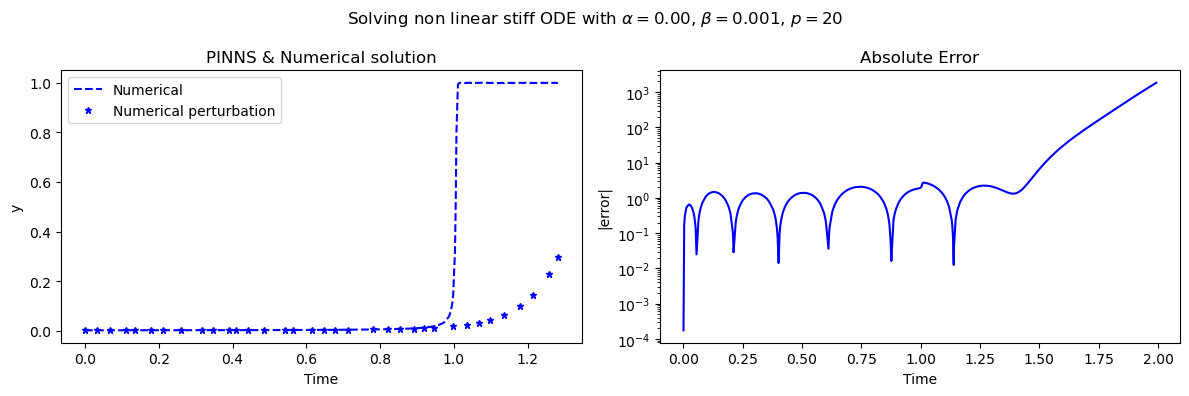

In [62]:
t_numpy = t_eval.detach().cpu().numpy()

fig, ax = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)
# plot PINNS solution
#ax[0].plot(t_numpy[:a*size//b], solution_PINNS[:a*size//b], c='blue', label='PINNS');

# plot Numerical solution
ax[0].plot(t_numpy[:a*size//b], non_linear_num_sol[:a*size//b], '--', c='blue', label="Numerical");

# plot numerical solution by perturbation
if compute_numerical_pert:
    ax[0].plot(t_numpy[:a*size//b:10], solution_numerical[:a*size//b:10], '*', c='blue', label='Numerical perturbation', markersize=5)

ax[0].set_xlabel("Time");
ax[0].set_ylabel("y");
ax[0].legend(loc="best");
ax[0].set_title(fr"PINNS & Numerical solution")

# plot errors
ax[1].plot(t_numpy, np.abs(solution_PINNS-non_linear_num_sol), c='blue', label='error');
ax[1].set_yscale('log')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('|error|')
ax[1].set_title('Absolute Error')

fig.suptitle(fr"Solving non linear stiff ODE with $\alpha={alpha_transfer:.2f}$, $\beta={beta:.3f}$, $p={p}$")


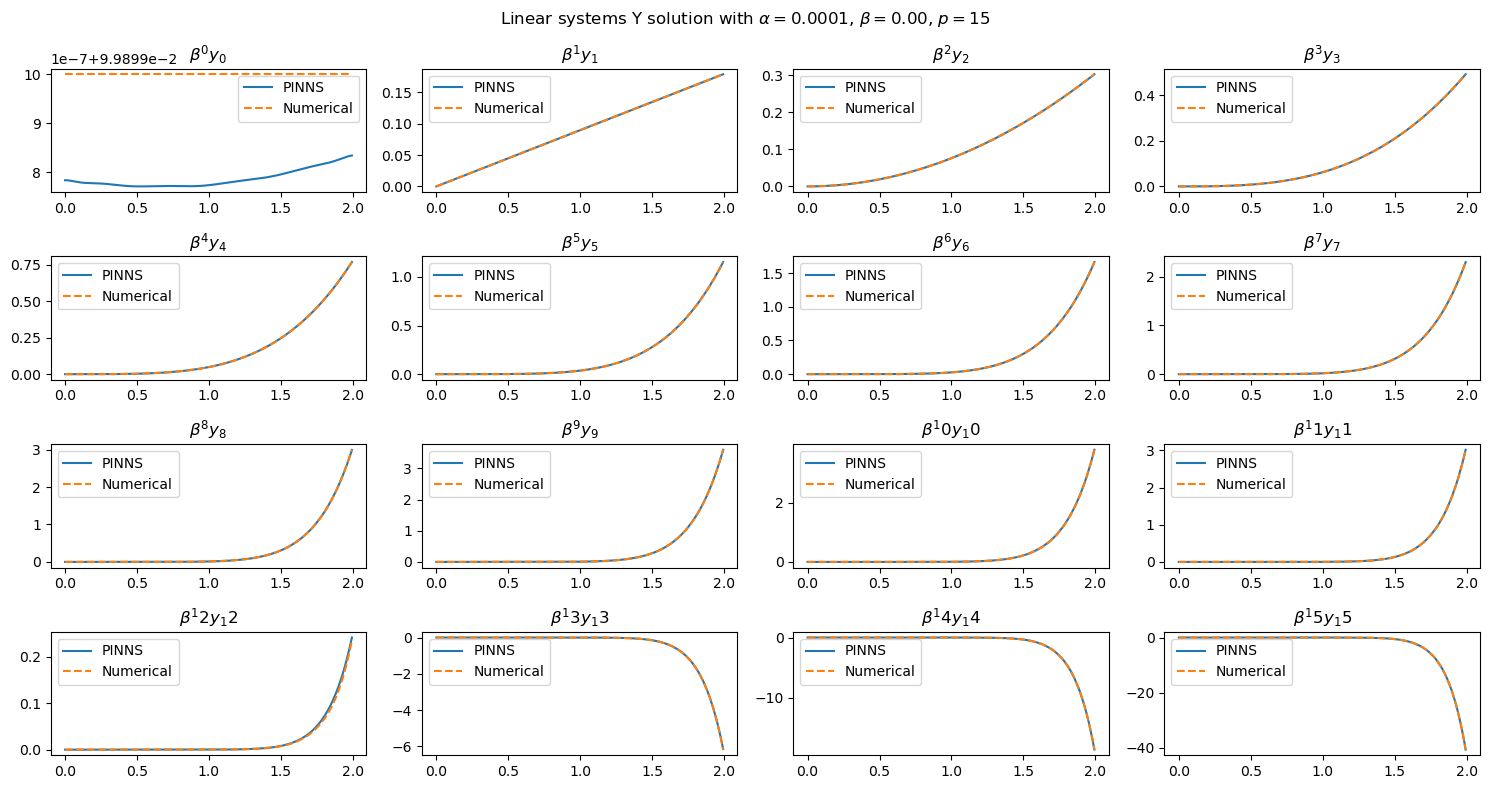

In [52]:
# plot Xi
nb_row_plot = (p+1)//4+1 if (p+1)%4!=0 else (p+1)//4
fig, ax = plt.subplots(nb_row_plot, 4, figsize=(15, nb_row_plot*2), tight_layout=True)
for i in range(p+1):
  j = i//4; k = i%4
  pert_coeff = (beta)**i
  ax[j][k].plot(t_numpy, PINNS_list[i]*pert_coeff, label="PINNS")
  if compute_numerical_pert:
    ax[j][k].plot(t_numpy, numerical_pert_list[i]*pert_coeff, '--', label="Numerical")
  ax[j][k].set_title(rf"$\beta^{i} y_{i}$")
  ax[j][k].legend(loc="best")
fig.suptitle(fr"Linear systems Y solution with $\alpha={alpha_transfer}$, $\beta={beta:.2f}$, $p={p}$")
fig.tight_layout()

In [51]:
#p_list = [i for i in range(0, 20, 3)]
p_list = [i for i in range(0, 10)]
compute_numerical_pert = False
sol_PINNS_list =[]; sol_PINNS_list_list =[]; sol_num_list = []; sol_num_list_list = []; total_time_list = []
for p in p_list:
  print("Solving p = {}".format(p))
  sp, sn, sp_list, sn_list, tt = solve_perturbation_TL(beta=beta, p=p, t_eval=t_eval,
                                                      alpha=alpha_transfer, A=A_transfer,
                                                      force=force_transfer.unsqueeze(1), IC=IC_transfer,
                                                      H=H, H_0=H_0, dH_dt=dH_dt_new, dev=dev,
                                                      force_func_index=force_func_index,
                                                      numerical_sol_fct=numerical_sol_fct,
                                                      force_function_PINNS=force_function_PINNS,
                                                      force_function_numerical=force_function_numerical,
                                                      compute_numerical_pert=compute_numerical_pert,
                                                      numerical_perturbation_fct=numerical_perturbation_fct,
                                                      verbose=False)
  sol_PINNS_list.append(sp)
  sol_num_list.append(sn)
  sol_PINNS_list_list.append(sp_list)
  sol_num_list_list.append(sn_list)
  total_time_list.append(tt)

Solving p = 0
Solving p = 1
Solving p = 2
Solving p = 3
Solving p = 4
Solving p = 5
Solving p = 6
Solving p = 7
Solving p = 8
Solving p = 9


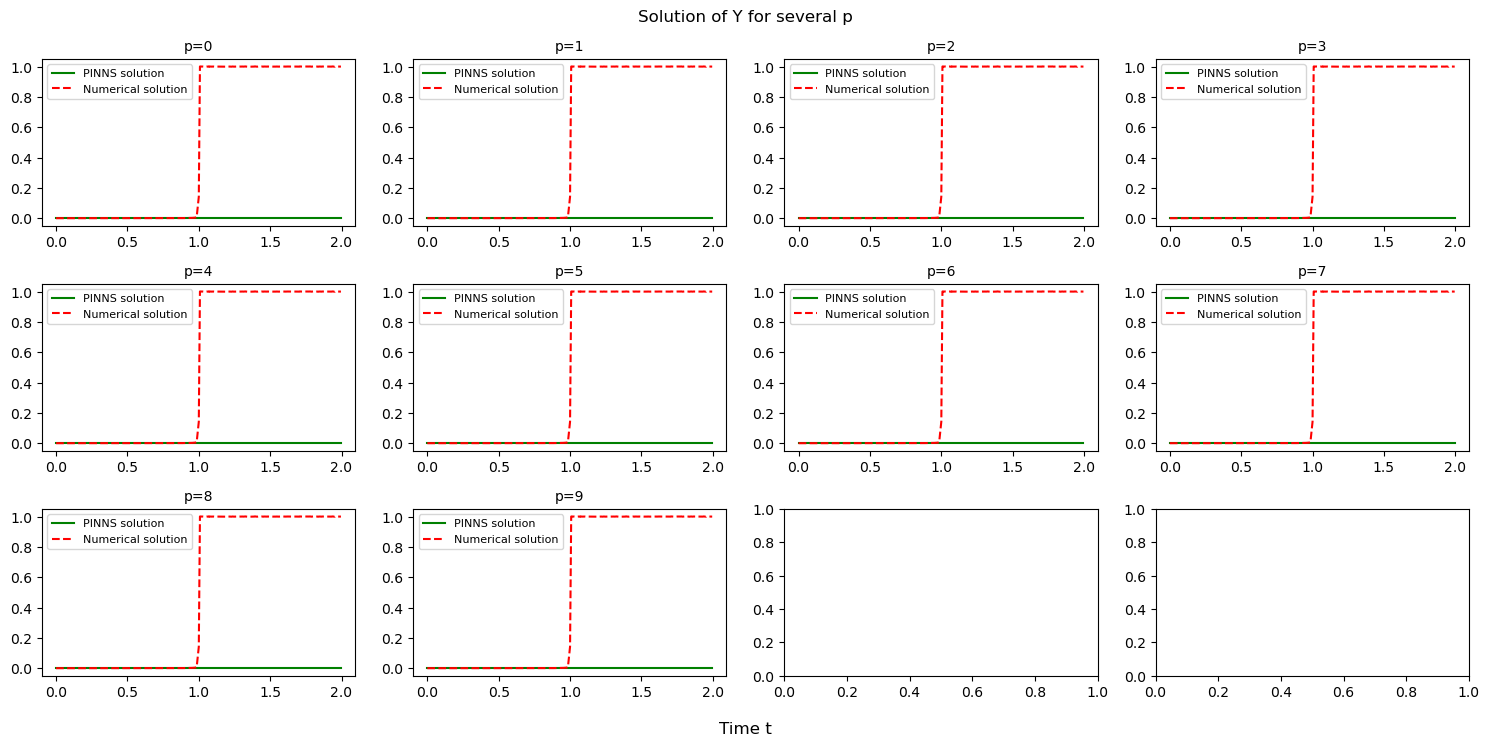

In [53]:
# Numerical - Numerical Perturbation X
nb_row_plot = (len(p_list)+1)//4+1 if (len(p_list))%4!=0 else (len(p_list)+1)//4
fig, ax = plt.subplots(nb_row_plot, 4, figsize=(15, nb_row_plot*2.5))
for i in range(len(p_list)):
  j = i//4; k = i%4
  ax[j][k].plot(t_numpy, sol_PINNS_list[i], 'g', label='PINNS solution')
  if compute_numerical_pert:
    ax[j][k].plot(t_numpy, sol_num_list[i], '--', label='Numerical solution by perturbation')
  ax[j][k].plot(t_numpy, non_linear_num_sol, '--r', label='Numerical solution')
  ax[j][k].legend(fontsize=8)
  ax[j][k].set_title(f"p={p_list[i]}", fontsize=10)
fig.supxlabel("Time t");
fig.suptitle("Solution of Y for several p");
fig.tight_layout()

# Comparative analysis with numerical methods on several alpha
- Solve iteratively for several alpha value
- Solve with:
    - PINNS transfer
    - RK45
    - Radeau
    - LSODA
- Get:
    - PINSS: Error + Time to compute
    - RK45: Error + Time to compute
    - Radau: Error + Time to compute
    - LSODA: Error + Time to compute

In [61]:
r_tol = 1e-4
numerical_sol_fct_radau = lambda x, IC, alpha, beta=beta, r_tol=r_tol, domain=domain: numerical_non_linear_solution(alpha, beta, IC, domain, x,
                                                                                                                    method="Radau", r_tol=r_tol).y

numerical_sol_fct_rk45 = lambda x, IC, alpha, beta=beta, r_tol=r_tol, domain=domain: numerical_non_linear_solution(alpha, beta, IC, domain, x,
                                                                                                                   method="RK45", r_tol=r_tol).y

numerical_sol_fct_lsoda = lambda x, IC, alpha, beta=beta, r_tol=r_tol, domain=domain: numerical_non_linear_solution(alpha, beta, IC, domain, x,
                                                                                                                   method="LSODA", r_tol=r_tol).y

numerical_methods = {"RK45": numerical_sol_fct_rk45, "Radau": numerical_sol_fct_radau, "LSODA": numerical_sol_fct_lsoda}

In [62]:
import time
from collections import defaultdict
from tqdm import tqdm


alpha_list_transfer = [2, 4, 8, 12, 20, 25, 30, 40, 50, 75, 100, 150, 200, 400]
# alpha_list_transfer = [i for i in range(2, 41, 2)]
IC_transfer = torch.tensor([[2.], [0.]], device=dev).double()
force_transfer = torch.tensor([[0.], [0.]], device=dev).double()
log_scale = True
p = 8


computational_time = defaultdict(list)
max_error = defaultdict(list)
mean_error = defaultdict(list)

solution = defaultdict(list)

length = t_eval.shape[0]

for alpha in tqdm(alpha_list_transfer):

    A_transfer = get_A(alpha)

    # solve with PINNS
    pinns_sol, _, _, _, total_time = solve_perturbation_TL(beta=beta, p=p, t_eval=t_eval,
                                                           alpha=alpha, A=A_transfer,
                                                           force=force_transfer, IC=IC_transfer,
                                                           H=H, H_0=H_0, dH_dt=dH_dt_new, dev=dev,
                                                           force_func_index=force_func_index,
                                                           numerical_sol_fct=numerical_sol_fct,
                                                           force_function_PINNS=force_function_PINNS,
                                                           force_function_numerical=force_function_numerical,
                                                           compute_numerical_pert=False,
                                                           numerical_perturbation_fct=numerical_perturbation_fct,
                                                           verbose=False)
    solution["PINNS"].append(pinns_sol.T)
    computational_time["PINNS"].append(total_time)

    # solve with numerical methods
    for method, fct in numerical_methods.items():
        start = time.time()
        numerical_sol = fct(t_eval.detach().cpu().numpy().squeeze(),
                            IC_transfer.detach().cpu().numpy().squeeze(),
                            alpha)
        solution[method].append(numerical_sol)
        end = time.time()
        computational_time[method].append(end-start)

    # # true solution
    # true_solution = true_solution_Dho(alpha, v[0].item(), v[1].item(), t_eval.detach().cpu().numpy())
    # solution["True"].append(true_solution)

    # # get error
    # max_error["PINNS"].append([]); 
    # mean_error["PINNS"].append([]); 
    # for method in numerical_methods.keys():
    #     max_error[method].append([])
    #     mean_error[method].append([])
    # for i in range(num_equations):
    #   # pinns error
    #   predicted_vals = pinns_sol[:, i, :].detach().cpu().numpy().squeeze()
    #   pinns_erros = np.abs(predicted_vals - true_solution[i, :])
    #   max_error["PINNS"][-1].append(pinns_erros.max())
    #   mean_error["PINNS"][-1].append(pinns_erros.mean())
    #   # Numerical error
    #   for method in numerical_methods.keys():
    #     sol = solution[method]
    #     numerical_error = np.abs(sol[-1][i] - true_solution[i])
    #     max_error[method][-1].append(numerical_error.max())
    #     mean_error[method][-1].append(numerical_error.mean())

100%|██████████| 14/14 [00:03<00:00,  4.35it/s]


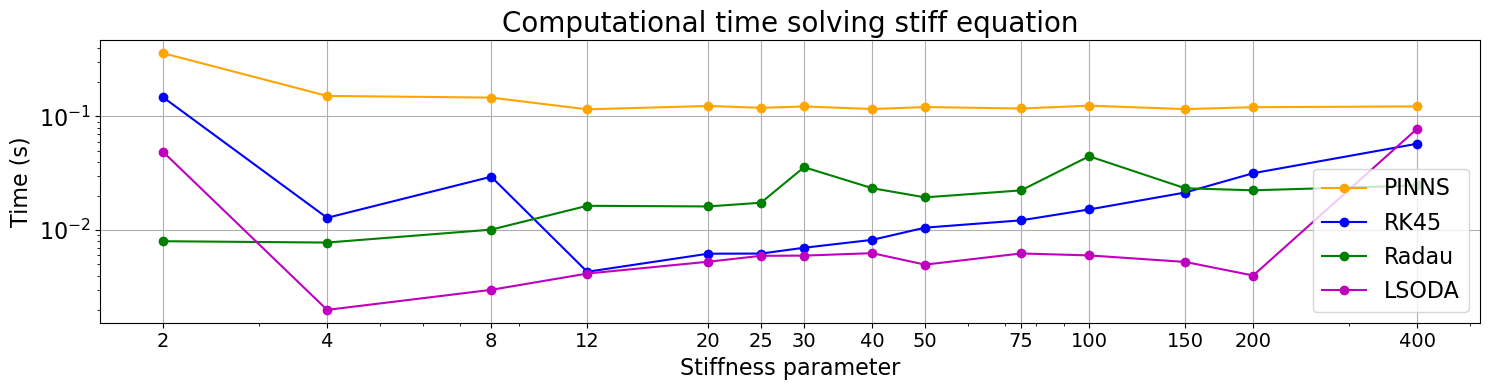

In [63]:
color = {"PINNS": 'orange', "RK45": 'b', "Radau": 'g', 'LSODA': 'm', "True": (1, 0, 0, 0.5)}
fig, ax = plt.subplots(1, tight_layout=True, figsize=(15, 4))

for method, time in computational_time.items():
    ax.plot(alpha_list_transfer, time, "-o", color=color[method], label=f"{method}")

ax.set_yscale("log")
if log_scale: ax.set_xscale("log")
ax.set_title("Computational time solving stiff equation", fontsize=20)
ax.set_xlabel('Stiffness parameter', fontsize=16)
ax.set_ylabel('Time (s)', fontsize=16)
ax.set_xticks(alpha_list_transfer, [str(i) for i in alpha_list_transfer])
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=16)
ax.legend(loc='best', fontsize=16)
ax.grid()

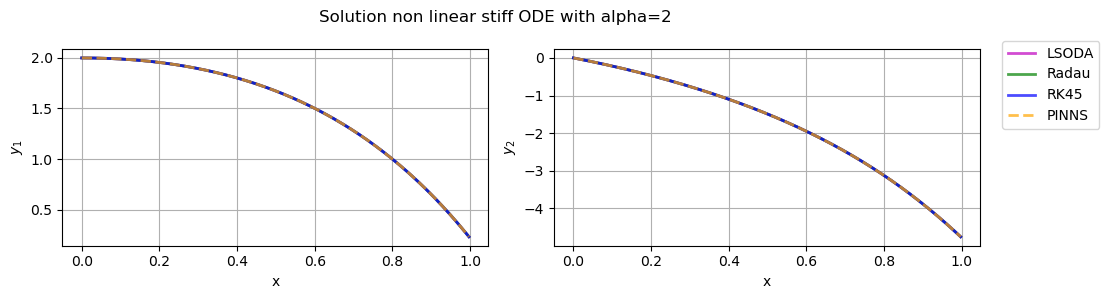

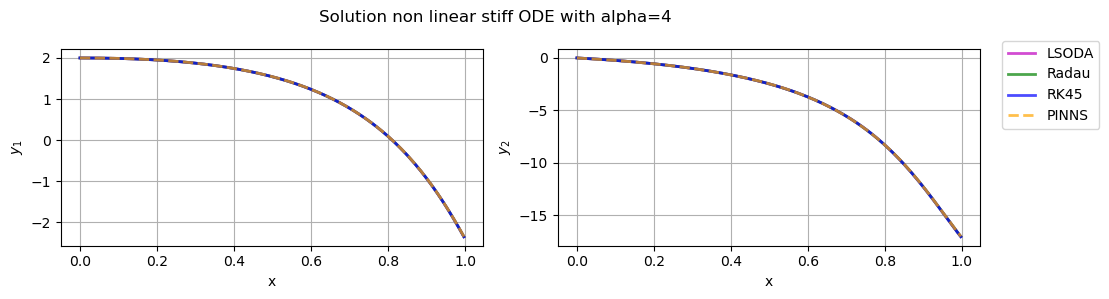

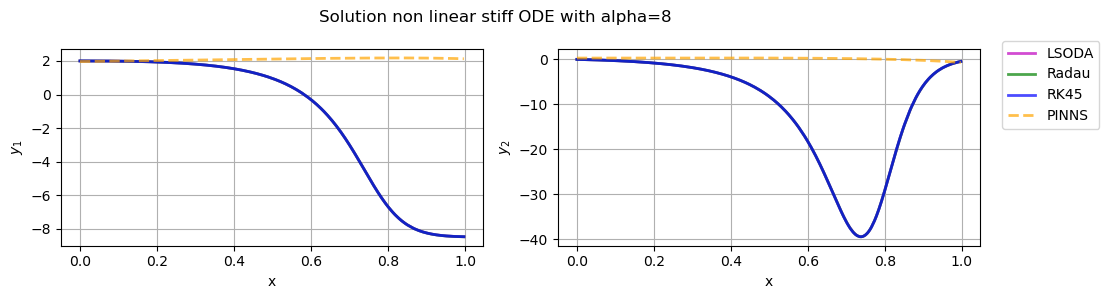

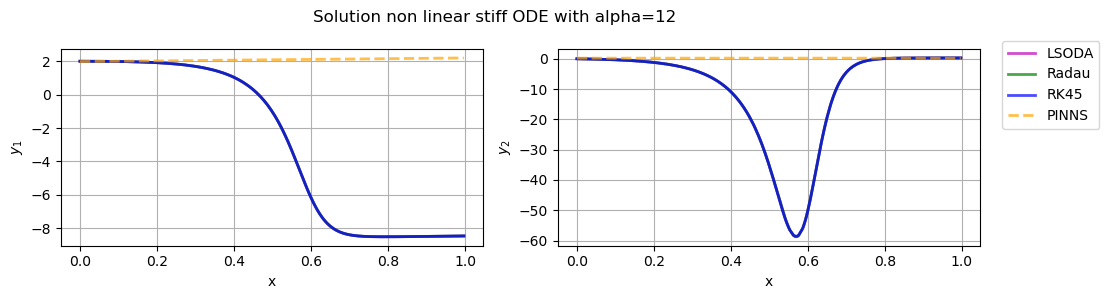

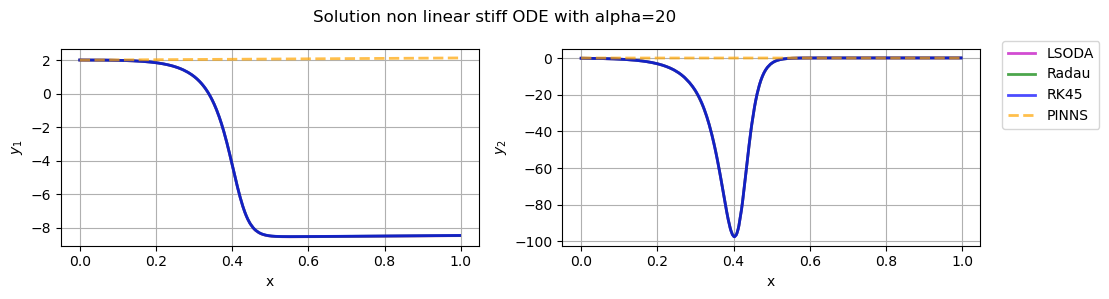

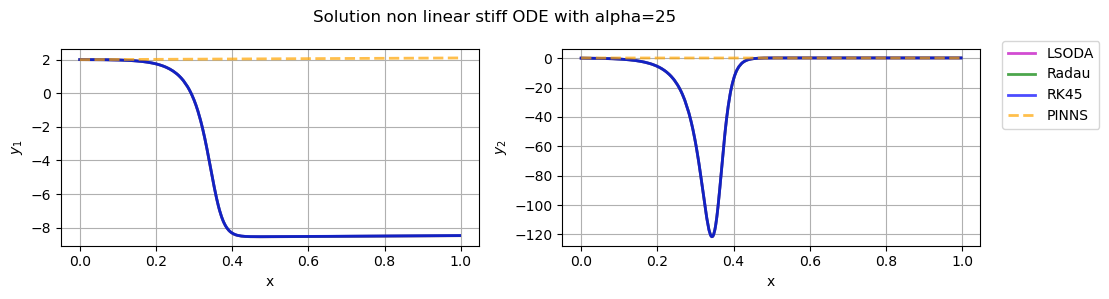

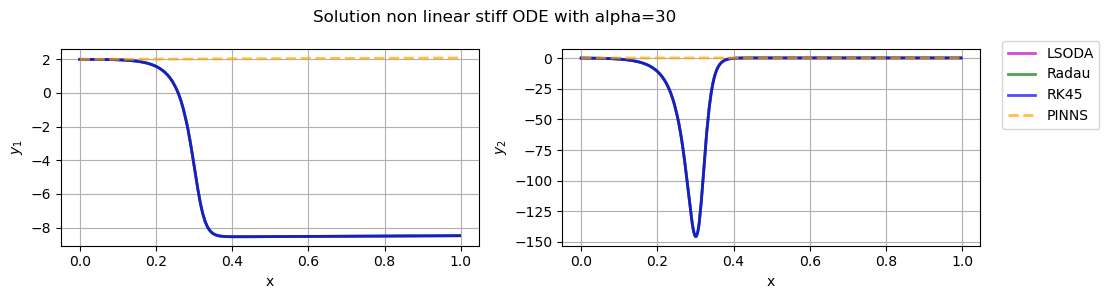

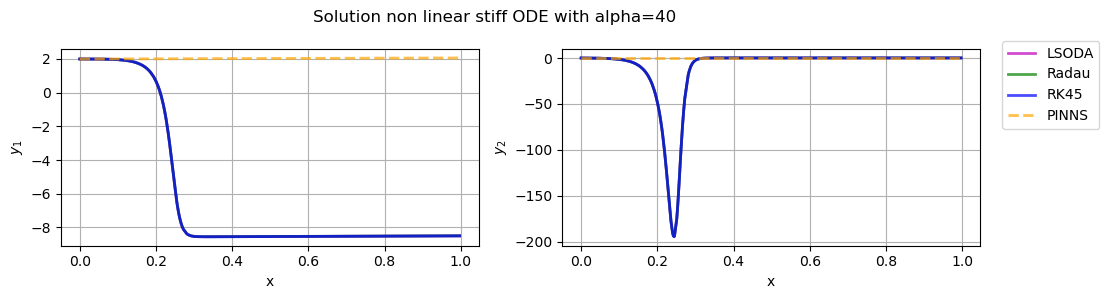

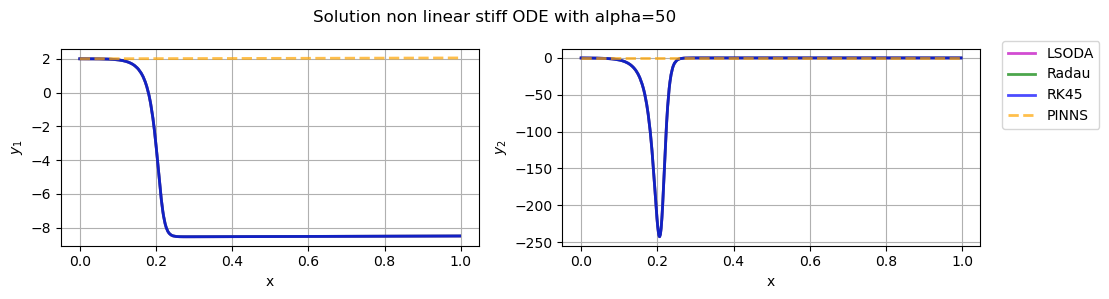

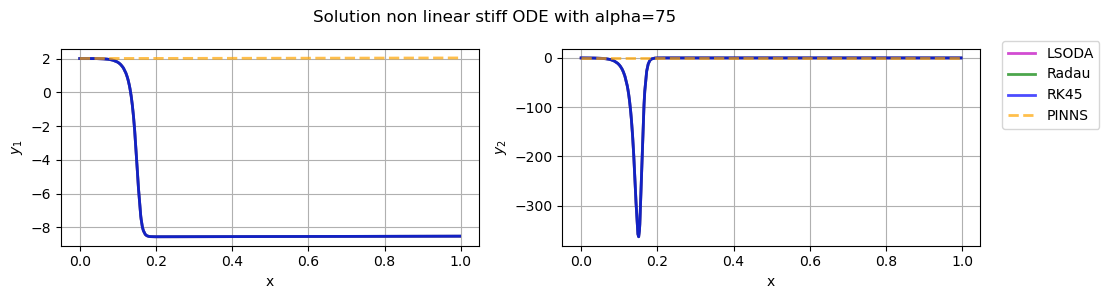

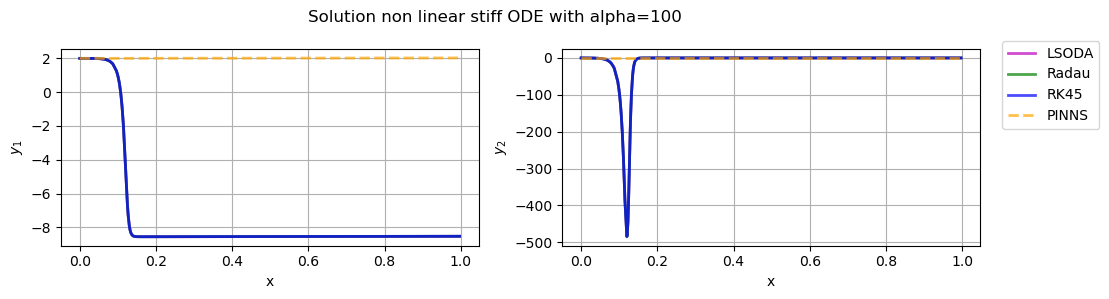

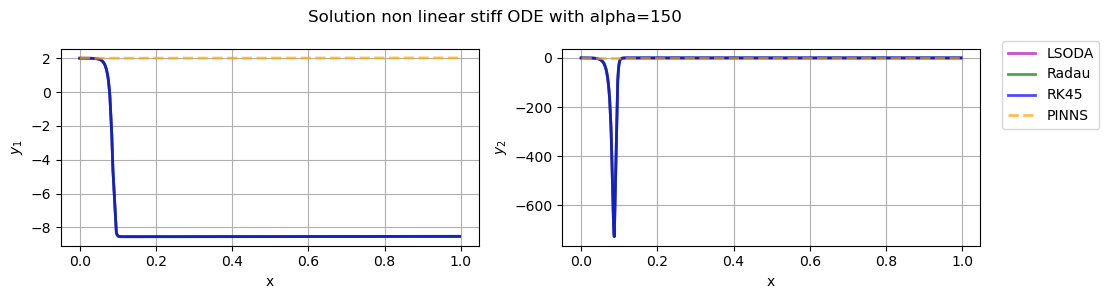

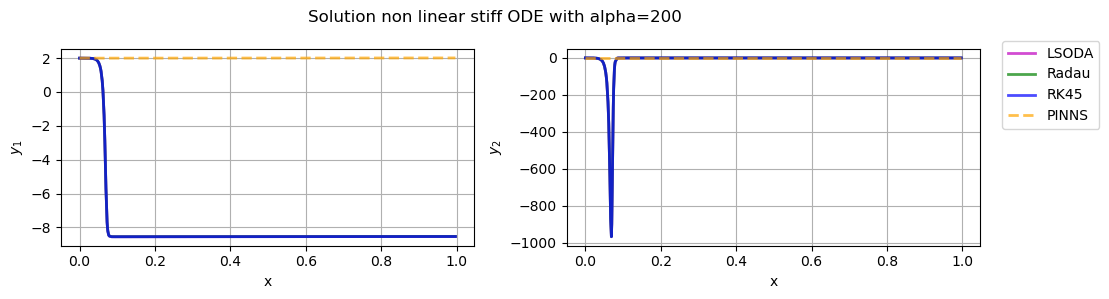

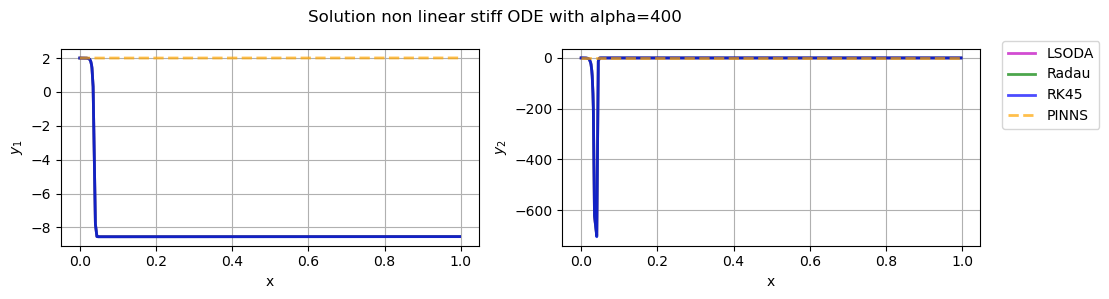

In [65]:
for i in range(len(alpha_list_transfer)):
    fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10, 3), sharex=True)
    for method, value in reversed(solution.items()):
        ax[0].plot(t_eval.detach().cpu().squeeze(), value[i][0, :].squeeze(), "--"if method=="PINNS" else "-",
                   color=color[method], label=f"{method}", alpha=0.7, linewidth=2)
        ax[1].plot(t_eval.detach().cpu().squeeze(), value[i][1, :].squeeze(), "--"if method=="PINNS" else "-",
                   color=color[method], alpha=0.7, linewidth=2)

    ax[0].set_xlabel('x')
    ax[0].set_ylabel('$y_1$')
    ax[0].tick_params(axis='x')
    ax[0].tick_params(axis='y')

    ax[0].grid()

    ax[1].set_xlabel('x')
    ax[1].set_ylabel('$y_2$')
    ax[1].tick_params(axis='x')
    ax[1].tick_params(axis='y')
    ax[1].grid()

    fig.suptitle(f"Solution non linear stiff ODE with alpha={alpha_list_transfer[i]}")
    fig.legend(loc='upper left', bbox_to_anchor=(1, 0.9))